# Comparing Fixed vs Optimized Hyper-Parameters on  the ExtraSensory dataset
using Cross-Validation


## Set up the Notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import importlib, sys, os
sys.path.insert(0, os.path.abspath('..'))
if(importlib.util.find_spec("mFlow") is None):
    !git clone https://github.com/mlds-lab/mFlow.git
    !pip install ./mFlow
else:
    print("mFlow module found")

mFlow module found


## Import modules

In [3]:
from mFlow.Blocks.data_loader_extrasensory import extrasensory_data_loader
from mFlow.Blocks.filter import MisingLabelFilter,  MisingDataColumnFilter, Take
from mFlow.Blocks.imputer import Imputer
from mFlow.Blocks.normalizer import Normalizer
from mFlow.Blocks.experimental_protocol import ExpTrainTest, ExpCV, ExpWithin
from mFlow.Blocks.results_analysis import ResultsConcat, ResultsCVSummarize, DataYieldReport

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import tree

import matplotlib.pyplot as plt

from mFlow.Workflow.workflow import workflow
import mFlow.Workflow.compute_graph



## Define the workflow

This workflow uses a basic train/test experiment to compare the use of default hyper-parameters to optimized hyper-parameters for the same model. We use logistic regression and decision trees as the models. To optimize hyper-parameters, we wrap a base model with Scikit-Learn's grid search cross-validation wrapper to provied hyper-parameter selection via nested cross-validation. The experiment uses the first 50,000  instances in the ExtraSensory data set. 

The workflow includes a column filter that screens out feature dimensions that are less than 20% observed, a missing label filter that removes instances without labels, mean imputation, and normalization. Next, the workflow includes one branch performing a train/test experiment for each model. Pre-processing is shared across all branches of the workflow. 

In the results below, we can see that logisitic regression outperforms the decision tree by more than 30% when the default hyper-parameters are used. However, the default decision tree hyper-parameters are quite poor for this task. Both models show improved performance using optimized hyper-parameters, with the decision tree improving to nearly match the performance of logistic regression. 

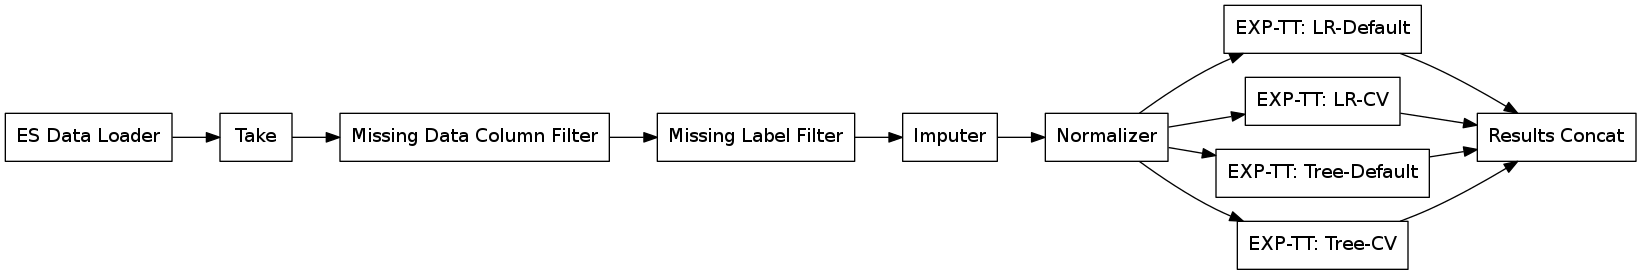

Running Sequential Scheduler

Running step ES Data Loader
  Loading Extrasensory pkl file...

Running step Take

Running step Missing Data Column Filter

Running step Missing Label Filter

Running step Imputer

Running step Normalizer

Running step EXP-TT: Tree-CV
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ........................................max_depth=2; total time=   9.3s
[CV] END ........................................max_depth=2; total time=  14.0s
[CV] END ........................................max_depth=2; total time=  16.7s
[CV] END ........................................max_depth=4; total time=   9.8s
[CV] END ........................................max_depth=4; total time=  11.7s
[CV] END ........................................max_depth=4; total time=   6.0s
[CV] END ........................................max_depth=6; total time=   7.0s
[CV] END ........................................max_depth=6; total time=  10.1s
[CV] END ..................

In [5]:
metrics     = [accuracy_score, f1_score, precision_score, recall_score]

df_raw      = extrasensory_data_loader(label="SLEEPING");
df_raw      = Take(df_raw, 50000)
df_cf       = MisingDataColumnFilter(df_raw);
df_lf       = MisingLabelFilter(df_cf);
df_imp      = Imputer(df_lf, method="mean")
df_norm     = Normalizer(df_imp)

models = {
              "LR-Default": LogisticRegression(solver="lbfgs",max_iter=1000),
              "LR-CV":      GridSearchCV(LogisticRegression(solver="lbfgs",max_iter=1000), 
                                    cv=3, verbose=2, param_grid={"C":[1e-2,1e-1,1,10,100]}),
              "Tree-Default":  tree.DecisionTreeClassifier(),
              "Tree-CV":    GridSearchCV(tree.DecisionTreeClassifier(), 
                                     cv=3, verbose=2, param_grid={"max_depth":[2,4,6,8,10]})
        }

res     = ExpTrainTest(df_norm, models, metrics=metrics);
res_cat = ResultsConcat(res)
flow    = workflow({"results":res_cat})
 
flow.draw(); plt.show();
output=flow.run();

In [6]:
output["results"]["report"]

,accuracy_score,f1_score,precision_score,recall_score
LR-Default,0.753527,0.345197,0.904290,0.213313
LR-CV,0.759218,0.374114,0.897929,0.236279
Tree-Default,0.678127,0.136176,0.372822,0.083301
Tree-CV,0.843154,0.695652,0.850394,0.588556
